Importamos las librerias necesarias:

In [6]:
#!pip install shapely
import json
import os
import matplotlib
import numpy as np
import pandas as pd

matplotlib.rcParams['font.family'] = 'Times New Roman'

Abrimos los archivos que utilizaremos:

In [7]:
imagenes = './images'
file_path = "./merged_file.json"

with open(file_path, 'r') as file:
    json_data = file.read()
    
data = json.loads(json_data)

Fijemonos cuáles son las imágenes que están en la carpeta pero no en el jason

In [8]:
import openpyxl

image_names_from_json = [item['item']['name'] for item in data]

image_names_from_json_set = set(image_names_from_json)

image_files = os.listdir(imagenes)

missing_images = []

for image_file in image_files:
    if image_file not in image_names_from_json_set:  
        missing_images.append(image_file)

if missing_images:
    print("Las siguientes imágenes están en la carpeta de imágenes pero no están presentes en el archivo JSON:")
    for image_name in missing_images:
        print(image_name)
else:
    print("Todas las imágenes de la carpeta de imágenes están presentes en el archivo JSON.")

missing_images_count = len(missing_images)
df = pd.DataFrame(missing_images, columns=['Missing Image Names'])
#df.to_excel('C:/Users/sofia/Documents/PROYECTO FINAL/missing_images.xlsx', index=False)

print(f"Hay {missing_images_count} imágenes en la carpeta de imágenes pero no están presentes en el archivo JSON.")

Las siguientes imágenes están en la carpeta de imágenes pero no están presentes en el archivo JSON:
labels_clusters.csv
Hay 1 imágenes en la carpeta de imágenes pero no están presentes en el archivo JSON.


Veamos las imagenes con mas y menos bounding boxes en relacion a su ancho sin contar las que no tienen bounding boxes

In [14]:
import requests
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO
import matplotlib.patches as patches

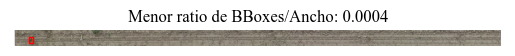

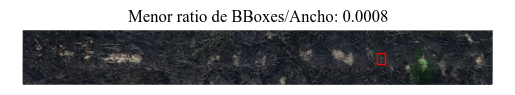

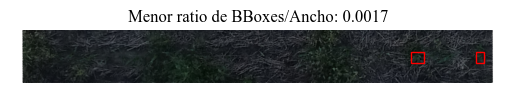

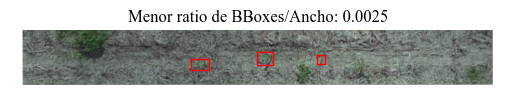

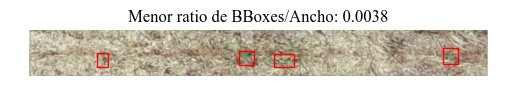

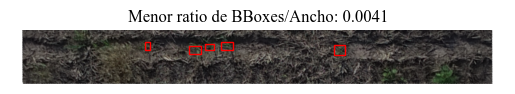

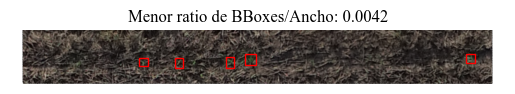

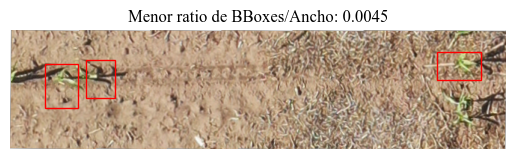

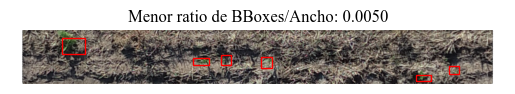

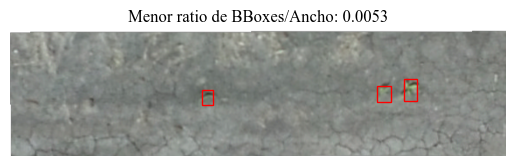

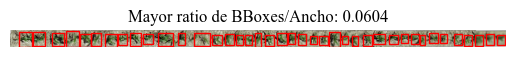

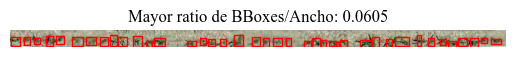

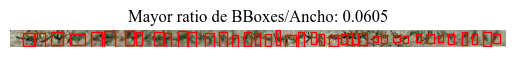

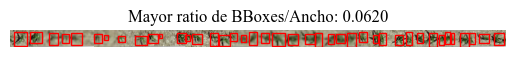

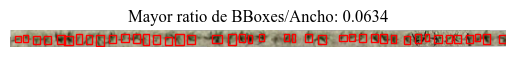

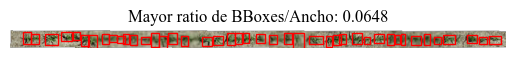

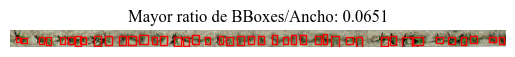

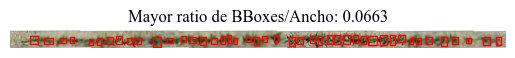

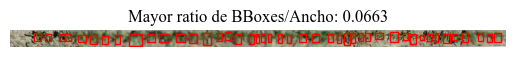

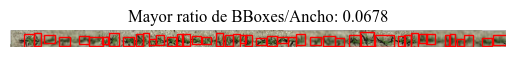

In [15]:
image_bboxes_ratio = []

for item in data:
    annotations = item.get('annotations', [])
    if not annotations:  
        continue

    image_url = item['item']['slots'][0]['source_files'][0]['url']
    image_width = item['item']['slots'][0]['width']
    image_bboxes = [(anno['bounding_box']['x'], anno['bounding_box']['y'], anno['bounding_box']['w'], anno['bounding_box']['h'])
                    for anno in annotations]

    if image_width > 0:
        ratio = len(annotations) / image_width
        image_bboxes_ratio.append((ratio, image_url, image_bboxes))

image_bboxes_ratio.sort(key=lambda x: x[0])
least_images = image_bboxes_ratio[:10]
most_images = image_bboxes_ratio[-10:]

def show_image_with_boxes(image_url, bboxes, title):
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))
    plt.figure()
    plt.imshow(image)
    ax = plt.gca()

    for (x, y, w, h) in bboxes:
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.title(title)
    plt.axis('off')
    plt.show()

for ratio, url, bboxes in least_images:
    show_image_with_boxes(url, bboxes, f"Menor ratio de BBoxes/Ancho: {ratio:.4f}")

for ratio, url, bboxes in most_images:
    show_image_with_boxes(url, bboxes, f"Mayor ratio de BBoxes/Ancho: {ratio:.4f}")


Veamos si hay alguna bounding box que haya sido colocada por error

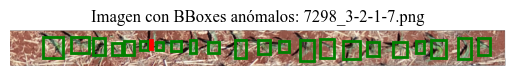

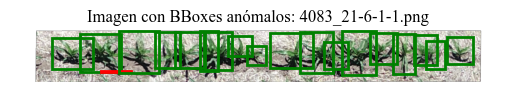

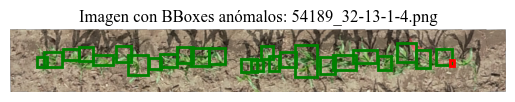

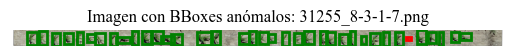

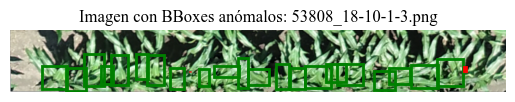

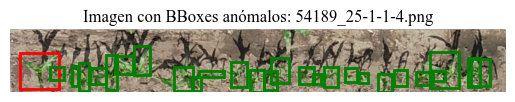

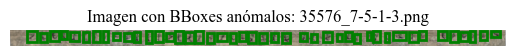

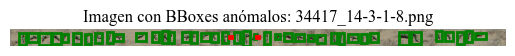

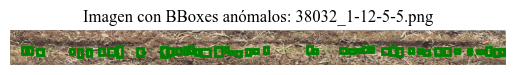

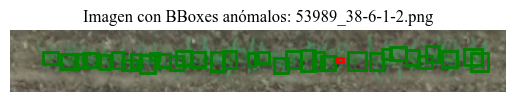

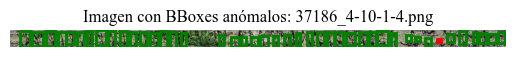

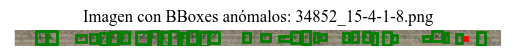

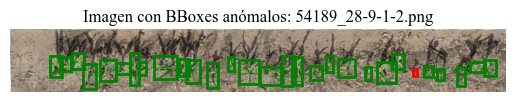

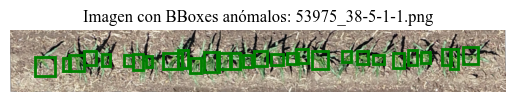

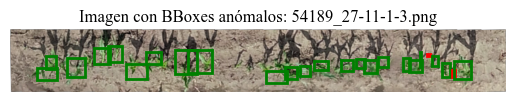

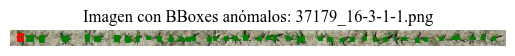

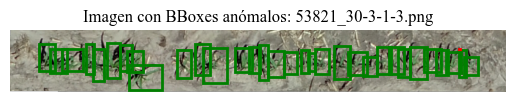

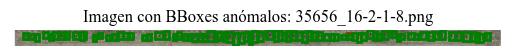

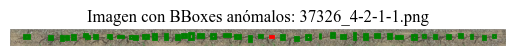

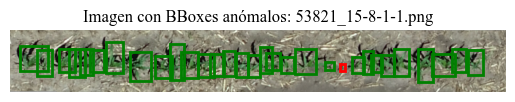

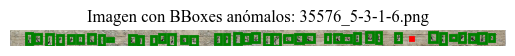

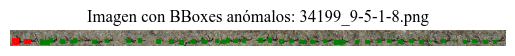

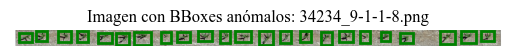

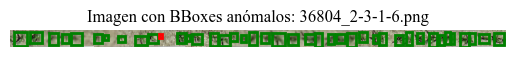

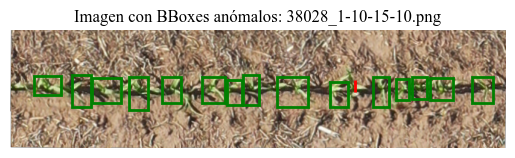

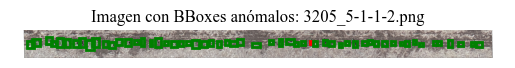

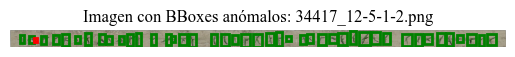

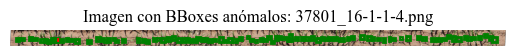

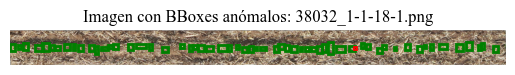

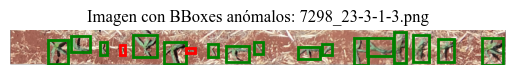

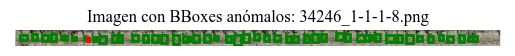

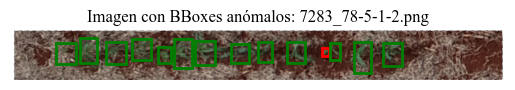

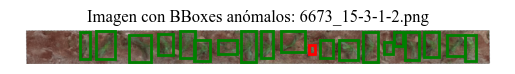

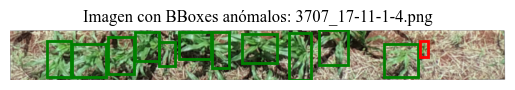

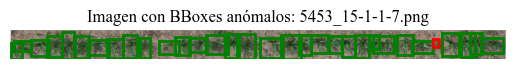

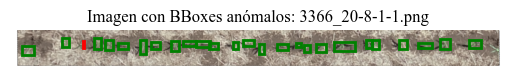

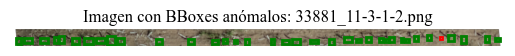

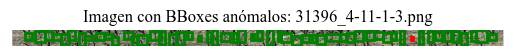

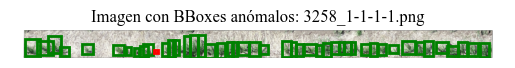

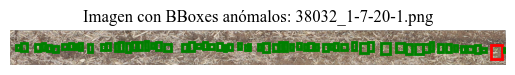

              Image Name        X       Y  Width  Height  Anomalous Area  \
0       7298_3-2-1-7.png   391.11   26.57   5.65   26.39        149.1035   
1      4083_21-6-1-1.png   240.63  109.31  80.94    0.59         47.7546   
2    54189_32-13-1-4.png   962.52   65.57   8.66   13.61        117.8626   
3      31255_8-3-1-7.png  2300.92   40.66  27.66   17.98        497.3268   
4    53808_18-10-1-3.png   341.94   78.74   1.08    1.08          1.1664   
5    53808_18-10-1-3.png   866.18   71.19   2.16    7.55         16.3080   
6     54189_25-1-1-4.png    21.53   50.11  84.77   80.35       6811.2695   
7      35576_7-5-1-3.png  2947.70    6.05   0.77    0.77          0.5929   
8     34417_14-3-1-8.png  1141.05   32.33  14.88   10.47        155.7936   
9     34417_14-3-1-8.png  1283.12   31.24  14.35   13.43        192.7205   
10    38032_1-12-5-5.png   271.89   78.43   0.45    0.45          0.2025   
11    53989_38-6-1-2.png   708.24   61.11  14.19    7.64        108.4116   
12    37186_

In [17]:
anomalous_data = []  

def show_image_with_boxes(image_url, bboxes, title):
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))
    plt.figure()
    plt.imshow(image)
    ax = plt.gca()

    for (x, y, w, h, anomalous) in bboxes:
        color = 'r' if anomalous else 'g'  
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

    plt.title(title)
    plt.axis('off')
    plt.show()

for item in data:
    annotations = item.get('annotations', [])
    image_url = item['item']['slots'][0]['source_files'][0]['url']
    image_name = item['item']['name']  

    areas = []
    bboxes_details = []
    for anno in annotations:
        x, y, w, h = anno['bounding_box']['x'], anno['bounding_box']['y'], anno['bounding_box']['w'], anno['bounding_box']['h']
        area = w * h
        areas.append(area)
        bboxes_details.append((x, y, w, h))

    if areas:
        median_area = np.median(areas)
        threshold_upper = 5 * median_area
        threshold_lower = 0.15 * median_area

        annotated_bboxes = []
        show = False
        for (x, y, w, h), area in zip(bboxes_details, areas):
            anomalous = area > threshold_upper or area < threshold_lower
            annotated_bboxes.append((x, y, w, h, anomalous))
            if anomalous:
                anomalous_data.append({
                    'Image Name': image_name,
                    'X': x,
                    'Y': y,
                    'Width': w,
                    'Height': h,
                    'Anomalous Area': area,
                    'Median Area': median_area
                })
                show = True

        if show:
            show_image_with_boxes(image_url, annotated_bboxes, f"Imagen con BBoxes anómalos: {image_name}")

df_anomalous_images = pd.DataFrame(anomalous_data)
print(df_anomalous_images)

df_anomalous_images.to_csv('./anomalous_images_details.csv', index=False)